Demonstration of the pipeline from $\mathcal{P}_{\zeta}$ to $\Omega_{GW}$
-------------------------------------------------------------------------

This notebook shows how to compute $\Omega_{\mathrm{GW}}(f)$ from a given $\mathcal{P}_\zeta(k)$ that is a callable function. We use a broken power law as an example. This code is optimized for speed.

In [28]:
# Imports
import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
from jax import jit

import numpy as np
import time

from sigwbinner.omega_gw_jax import OmegaGWjax
import matplotlib
import matplotlib.pyplot as plt
# If necessary you can comment out everything below this line
# Use SVG backend for better resolution
%config InlineBackend.figure_format = 'svg'
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [29]:
# Global parameters
# Define frequency range in LISA band
fstart = 1e-5 
fend = 1e0
nf = 200
fvals = jnp.geomspace(fstart, fend, nf)

In [30]:
############################################
####        Fiducial parameters         ####
############################################

# For both
logA = -2.71028683
alpha = 3.10673309
beta = 0.22154827
gamma = 1.25417717
logks = -1.58150632

params = [logA, alpha, beta, gamma, logks]

In [31]:
# Define Model

# Needs less accuracy in s
ns = 10
s = jnp.linspace(0., 1., ns)

# Here t is a function that depends on the parameters of P_zeta
# since we know how the function looks like. This allows us to compute the
# [0, infty] integral in a more efficient way by focussing on the relevant
# region of the integral.
@jit
def t(k, logA, alpha, beta, gamma, logks):
    ks = 10.0**logks
    nt_low = 100
    nt_high = 300
    lower_t = 1e-6 * jnp.ones_like(k)
    # print(jnp.array(10**(6 / beta) / (k / ks)).shape)
    upper_t = jnp.min(jnp.array([10**(6. / beta) / (k / ks), 10**4 / (k / ks)]), axis=0)
    upper_t = jnp.where(upper_t > 1e5*ks, 1e5*ks, upper_t)
    t1 = jnp.linspace(lower_t, 0.999*jnp.ones(lower_t.shape), nt_low)
    t2 = jnp.geomspace(1.*jnp.ones_like(upper_t), upper_t, nt_high)
    t_tot = jnp.concatenate([t1, t2], axis=0)
    return t_tot

# P_zeta is a function. It makes sense to jit it since it is called many times.
@jit
def pzeta_bpl(k, logA, alpha, beta, gamma, logks):
    A = 10.0**logA
    ks = 10.0**logks
    term1 = A  * (alpha + beta)**gamma
    term2 = (beta*(k/ks)**(-alpha/gamma) + alpha*(k/ks)**(beta/gamma))**(gamma)
    return term1 / term2

signal_model = OmegaGWjax(
    pzeta_bpl, s, t, f=fvals, norm="RD", 
    kernel="RD", upsample=True, dP_zeta="auto")

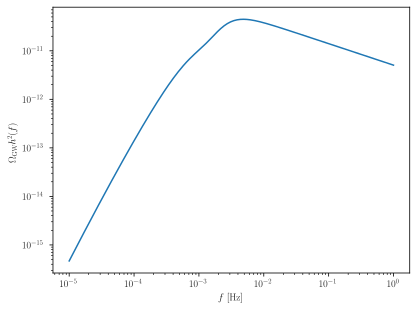

In [32]:
# Plot Omega_GW
plt.figure()
plt.loglog(fvals, signal_model(fvals, *params))
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$\Omega_{\rm GW}h^2 (f)$')
plt.show()


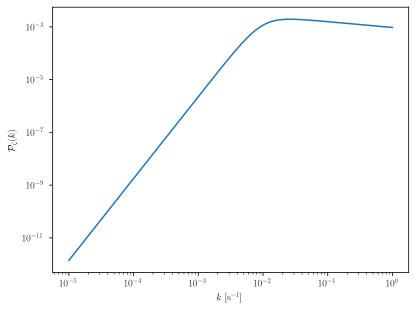

In [33]:
# Plot P_zeta
kvals = jnp.geomspace(1e-5, 1e0, 200)
plt.figure()
plt.loglog(kvals, signal_model.P_zeta(kvals, *params))
plt.xlabel(r'$k$ [s$^{-1}$]')
plt.ylabel(r'$\mathcal{P}_{\zeta}(k)$')
plt.show()